<a href="https://colab.research.google.com/github/Tahiyat07/NN-paper/blob/main/Distilbart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/COVID-19_Sentiments.csv')  # Adjust path if needed
df = df[['Text', 'Sentiments']].dropna()  # Drop missing values
df = df.sample(n=10000, random_state=42)  # Reduce size for Colab memory



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convert float sentiment to class labels: 0=Negative, 1=Neutral, 2=Positive
def convert_label(value):
    if value < 0:
        return 0
    elif value == 0:
        return 1
    else:
        return 2

df['sentiment'] = df['Sentiments'].apply(convert_label)



In [ ]:
# Split into features and labels
X = list(df['Text'])
y = list(df['sentiment'])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Tokenization using DistilBERT
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_enc = tokenizer(X_train, truncation=True, padding=True, return_tensors="tf")
X_test_enc = tokenizer(X_test, truncation=True, padding=True, return_tensors="tf")

# Convert labels to TensorFlow tensors
import tensorflow as tf
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Load DistilBERT model for sequence classification (3 classes)
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Train model: 3 epochs, 300 steps per epoch (batch_size=16 → 4800 samples per epoch)
model.fit(
    x=dict(X_train_enc),
    y=y_train,
    epochs=3,
    batch_size=16,
    steps_per_epoch=300,
    validation_data=(dict(X_test_enc), y_test)
)

# Predict on test set
preds = model.predict(dict(X_test_enc))
y_pred = tf.argmax(preds.logits, axis=1).numpy()

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report
y_true = y_test.numpy()

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(
    y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
300/300 [==============================] - 166s 480ms/step - loss: 0.6894 - accuracy: 0.6998 - val_loss: 0.3919 - val_accuracy: 0.8735
Epoch 2/3
300/300 [==============================] - 149s 497ms/step - loss: 0.3522 - accuracy: 0.8844 - val_loss: 0.3081 - val_accuracy: 0.9070
Epoch 3/3
63/63 [==============================] - 11s 150ms/step
Confusion Matrix:
 [[281  41  62]
 [  4 797  24]
 [ 12  19 760]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.73      0.83       384
     Neutral       0.93      0.97      0.95       825
    Positive       0.90      0.96      0.93       791

    accuracy                           0.92      2000
   macro avg       0.92      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000



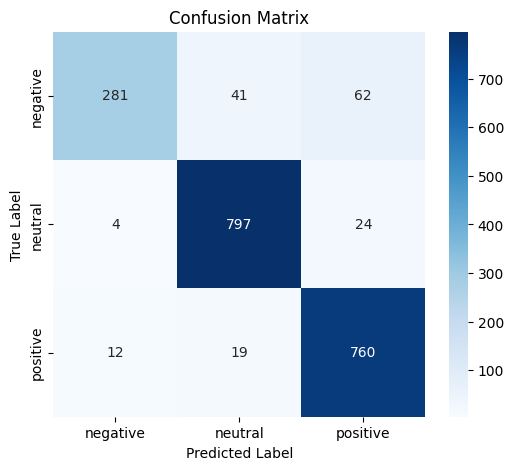

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure y_true and y_pred are correctly defined
y_true = y_test.numpy()  # Convert y_test to numpy array (true labels)
y_pred = tf.argmax(preds.logits, axis=1).numpy()  # Get predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # 0=negative, 1=neutral, 2=positive

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
